# Predicting Footballer Ratings

![](http://images.ali213.net/picfile/pic/2015/09/11/20150911104451473.jpg)

# Load data

In [51]:
import pandas as pd
from sqlalchemy import create_engine

In [52]:
DATABASE_ENGINE = create_engine('sqlite:///database.sqlite')

In [53]:
player_stats = pd.read_sql(sql="SELECT * FROM player_stats", con=DATABASE_ENGINE, index_col='id')

# Take most recent stat for each player

In [57]:
most_recent_stat_mask = ( player_stats.groupby(['player_api_id', 'player_fifa_api_id'])['date_stat'].transform(max) == player_stats['date_stat'] )

player_stats = player_stats[most_recent_stat_mask]

# Select a few columns we care about

In [59]:
columns = ['overall_rating', 'ball_control', 'short_passing', 'finishing', 'reactions']

player_stats = player_stats[columns]

In [60]:
player_stats.head()

,overall_rating,ball_control,short_passing,finishing,reactions
id,,,,,
1,67.0,49.0,61.0,44.0,47.0
6,74.0,71.0,71.0,53.0,67.0
39,65.0,67.0,66.0,58.0,51.0
65,69.0,62.0,65.0,21.0,57.0
88,70.0,58.0,65.0,34.0,68.0


# Handle null values

In [61]:
player_stats[player_stats.isnull().any(axis=1)]

,overall_rating,ball_control,short_passing,finishing,reactions
id,,,,,
129706,NaN,NaN,NaN,NaN,NaN
138887,NaN,NaN,NaN,NaN,NaN


In [62]:
player_stats.dropna(inplace=True)

# Visualize our covariates

In [64]:
%matplotlib inline

import matplotlib.pyplot as plt

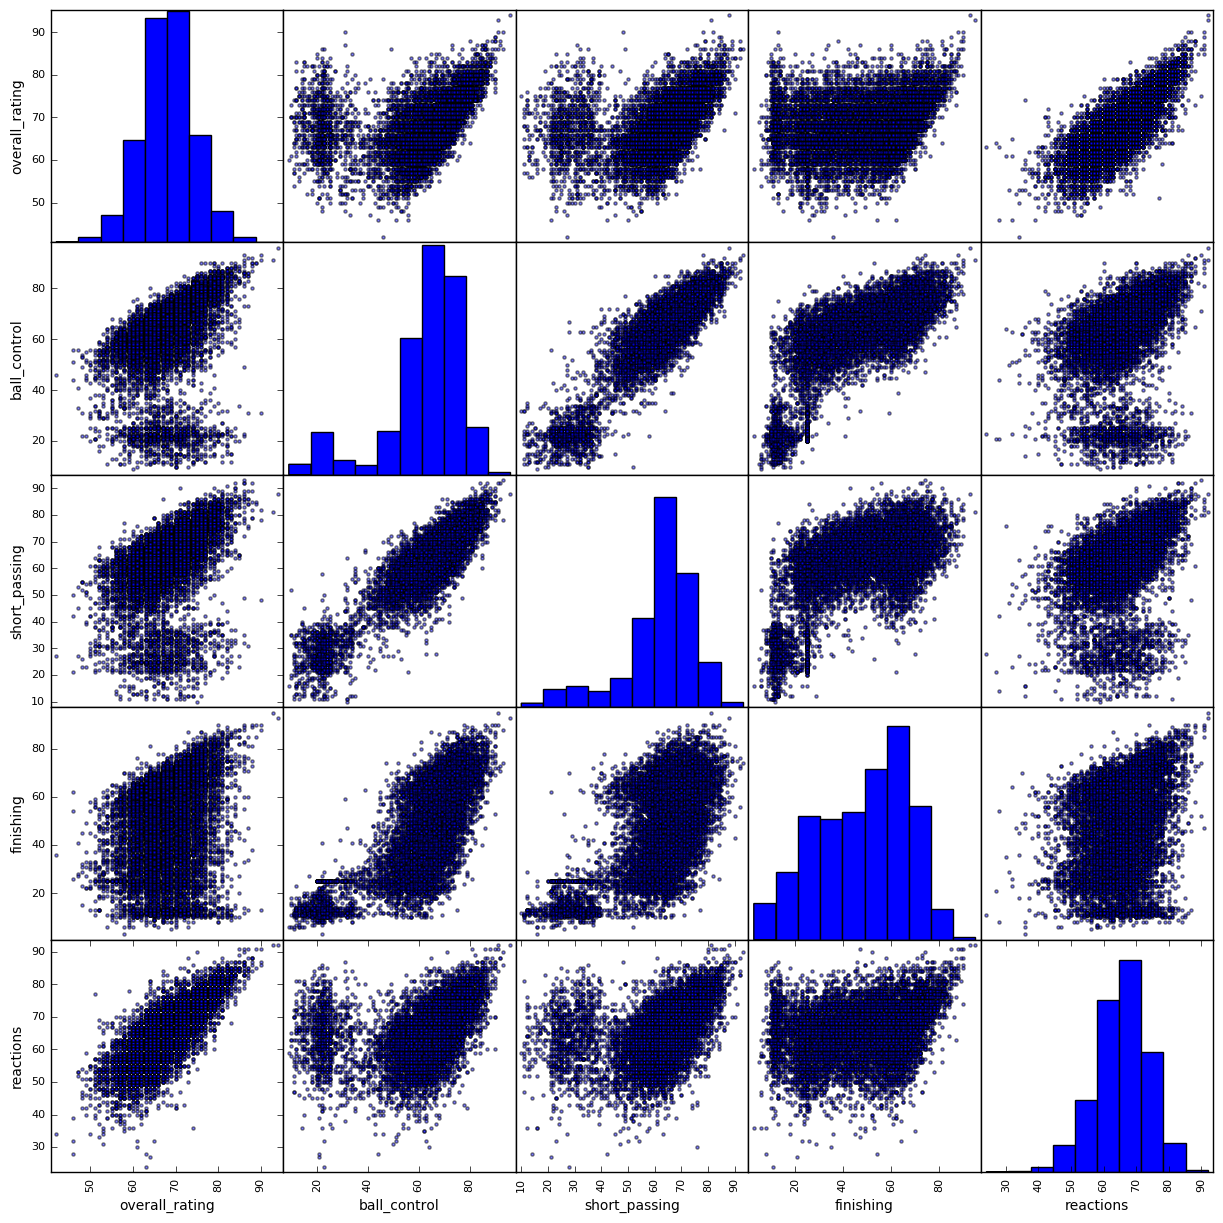

In [65]:
pd.scatter_matrix(player_stats, figsize=(15, 15), diagonal='hist')
plt.show()

# Fit a model

## Separate X, y

In [66]:
y = player_stats.pop('overall_rating')
X = player_stats

## Scale our data

In [69]:
from sklearn.preprocessing import MinMaxScaler

In [70]:
X_scaled = MinMaxScaler().fit_transform(X)

## Separate train, validation sets

In [71]:
import numpy as np

In [72]:
training_indices = np.random.binomial(n=1, p=.7, size=len(X_scaled)).astype(bool)

In [73]:
X_train = X_scaled[training_indices]
y_train = y[training_indices]

X_validation = X_scaled[~training_indices]
y_validation = y[~training_indices]

## Define an error metric

In [74]:
def root_mean_squared_error(y_true, y_predicted):
    return np.sqrt( np.mean( (y_predicted - y_true)**2 ) )

## Fit a linear model

In [75]:
from sklearn.linear_model import LinearRegression

In [76]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

y_predicted = linear_regression_model.predict(X_validation)
rmse = root_mean_squared_error(y_true=y_validation, y_predicted=y_predicted)

In [77]:
print('Root mean squared error: {}'.format( round(rmse, 3) ))

Root mean squared error: 3.899


In [79]:
linear_regression_model.coef_

array([  2.59691967,   3.37528638,  -1.78181429,  38.00844346])

## Fit a non-linear model

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

y_predicted = random_forest_model.predict(X_validation)
rmse = root_mean_squared_error(y_true=y_validation, y_predicted=y_predicted)

In [82]:
print('Root mean squared error: {}'.format( round(rmse, 3) ))

Root mean squared error: 3.512


In [83]:
random_forest_model.feature_importances_

array([ 0.16532769,  0.08425156,  0.10745319,  0.64296756])